In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [3]:
df = pd.read_csv("climate_nasa.csv")

print(df.shape)

(522, 5)


In [4]:
print(df.columns)

Index(['date', 'likesCount', 'profileName', 'commentsCount', 'text'], dtype='object')


In [5]:
print(df.head())

                       date  likesCount  \
0  2022-09-07T17:12:32.000Z           2   
1  2022-09-08T14:51:13.000Z           0   
2  2022-09-07T17:19:41.000Z           1   
3  2022-09-08T00:51:30.000Z           4   
4  2022-09-07T19:06:20.000Z          16   

                                         profileName  commentsCount  \
0  4dca617d86b3fdce80ba7e81fb16e048c9cd9798cdfd6d...            NaN   
1  518ab97f2d115ba5b6f03b2fba2ef2b120540c9681288b...            NaN   
2  d82e8e24eb633fd625b0aef9b3cb625cfb044ceb8483e1...            3.0   
3  37a509fa0b5177a2233c7e2d0e2b2d6916695fa9fba3f2...            NaN   
4  e54fbbd42a729af9d04d9a5cc1f9bbfe8081a31c219ecb...           26.0   

                                                text  
0  Neat comparison I have not heard it before.\n ...  
1  An excellent way to visualise the invisible! T...  
2  Does the CO2/ghg in the troposphere affect the...  
3  excellent post! I defo feel the difference - o...  
4  Yes, and carbon dioxide does not har

In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522 entries, 0 to 521
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           522 non-null    object 
 1   likesCount     522 non-null    int64  
 2   profileName    522 non-null    object 
 3   commentsCount  244 non-null    float64
 4   text           504 non-null    object 
dtypes: float64(1), int64(1), object(3)
memory usage: 20.5+ KB
None


In [7]:
print(df.isnull().sum())

date               0
likesCount         0
profileName        0
commentsCount    278
text              18
dtype: int64


In [8]:
df = df.dropna(subset=['text']).reset_index(drop=True)

In [9]:
df['commentsCount'] = df['commentsCount'].fillna(0)

In [10]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           504 non-null    object 
 1   likesCount     504 non-null    int64  
 2   profileName    504 non-null    object 
 3   commentsCount  504 non-null    float64
 4   text           504 non-null    object 
dtypes: float64(1), int64(1), object(3)
memory usage: 19.8+ KB
None


In [11]:
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download required NLTK data files (run once)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize and remove stopwords, then lemmatize
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    # Join back tokens to string
    return ' '.join(tokens)

# Apply cleaning function to the 'text' column
df['clean_text'] = df['text'].apply(clean_text)

# Check sample cleaned text
print(df[['text', 'clean_text']].head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


                                                text  \
0  Neat comparison I have not heard it before.\n ...   
1  An excellent way to visualise the invisible! T...   
2  Does the CO2/ghg in the troposphere affect the...   
3  excellent post! I defo feel the difference - o...   
4  Yes, and carbon dioxide does not harm the Eart...   

                                          clean_text  
0  neat comparison heard would say co2 like disco...  
1           excellent way visualise invisible thanks  
2  co2ghg troposphere affect stratosphere warmer ...  
3  excellent post defo feel difference one drink ...  
4  yes carbon dioxide harm earth like people maki...  


In [12]:
from textblob import TextBlob

# Function to get sentiment polarity
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply to cleaned text
df['sentiment'] = df['clean_text'].apply(get_sentiment)

# Show results
print(df[['clean_text', 'sentiment']].head())

# Optional: classify sentiment as Positive, Negative, Neutral
def sentiment_label(score):
    if score > 0.1:
        return 'Positive'
    elif score < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_label'] = df['sentiment'].apply(sentiment_label)
print(df['sentiment_label'].value_counts())


                                          clean_text  sentiment
0  neat comparison heard would say co2 like disco...   0.000000
1           excellent way visualise invisible thanks   0.600000
2  co2ghg troposphere affect stratosphere warmer ...   0.000000
3  excellent post defo feel difference one drink ...   0.142857
4  yes carbon dioxide harm earth like people maki...  -0.375000
sentiment_label
Neutral     294
Positive    144
Negative     66
Name: count, dtype: int64


In [15]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Download vader lexicon if not already done
nltk.download('vader_lexicon')

# Initialize VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Apply sentiment analysis to 'text' column and create new columns
df['sentiment_scores'] = df['text'].apply(lambda x: sid.polarity_scores(str(x)))

# Extract compound score into its own column
df['compound'] = df['sentiment_scores'].apply(lambda score_dict: score_dict['compound'])

# Optionally, create sentiment labels based on compound score thresholds
def label_sentiment(compound):
    if compound >= 0.05:
        return 'Positive'
    elif compound <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_label'] = df['compound'].apply(label_sentiment)

# Now you can run
daily_sentiment = df.groupby(df['date'].dt.date)['compound'].mean().reset_index()


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


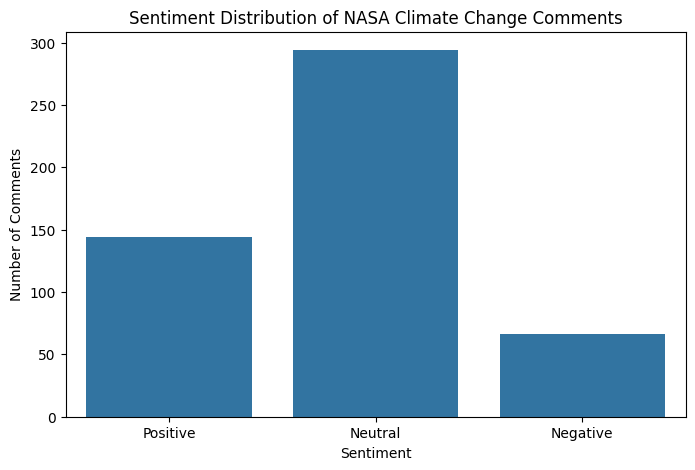

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# First, convert 'date' to datetime
df['date'] = pd.to_datetime(df['date'])

# Plot 1: Sentiment distribution
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='sentiment_label', order=['Positive', 'Neutral', 'Negative'])
plt.title('Sentiment Distribution of NASA Climate Change Comments')
plt.xlabel('Sentiment')
plt.ylabel('Number of Comments')
plt.show()

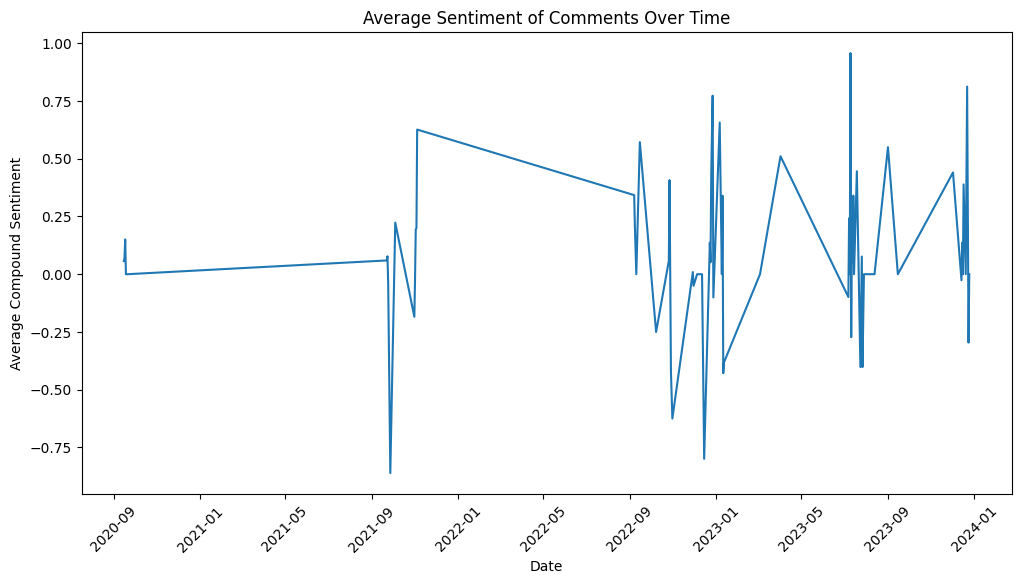

In [16]:
# Plot 2: Sentiment over time (average compound sentiment by day)
# Group by date and calculate mean sentiment
daily_sentiment = df.groupby(df['date'].dt.date)['compound'].mean().reset_index()
daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])

plt.figure(figsize=(12,6))
sns.lineplot(data=daily_sentiment, x='date', y='compound')
plt.title('Average Sentiment of Comments Over Time')
plt.xlabel('Date')
plt.ylabel('Average Compound Sentiment')
plt.xticks(rotation=45)
plt.show()

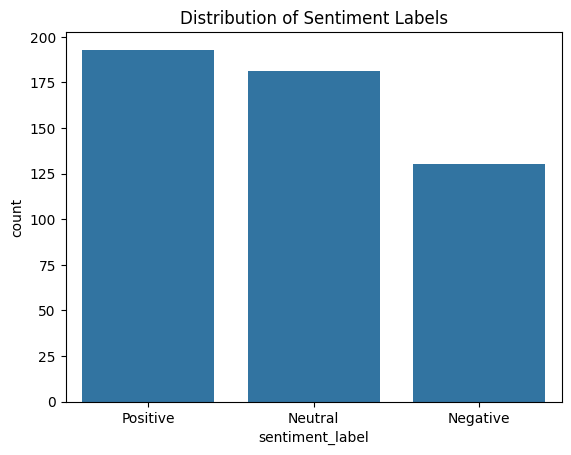

In [18]:
sns.countplot(data=df, x='sentiment_label', order=['Positive', 'Neutral', 'Negative'])
plt.title('Distribution of Sentiment Labels')
plt.show()

In [19]:
from collections import Counter
import re

positive_text = df[df['sentiment_label']=='Positive']['text'].dropna().str.cat(sep=' ').lower()
positive_words = re.findall(r'\b\w+\b', positive_text)

common_words_pos = Counter(positive_words).most_common(20)
print("Top 20 words in Positive comments:", common_words_pos)

Top 20 words in Positive comments: [('the', 538), ('to', 262), ('of', 236), ('and', 214), ('is', 180), ('in', 166), ('a', 161), ('it', 125), ('that', 116), ('we', 108), ('for', 95), ('s', 92), ('i', 86), ('this', 74), ('are', 70), ('climate', 62), ('about', 62), ('earth', 60), ('you', 60), ('by', 60)]
